# 아래 코드는 https://github.com/kimwoonggon/publicservant_AI를 참고하여 작석했습니다.

In [0]:
import pandas as pd
import os
from google.colab import drive
drive.mount('/content/gdrive/')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [0]:
path='gdrive/My Drive/HUB/sms-spam-collection-dataset/spam.csv'
os.listdir("gdrive/My Drive/HUB/sms-spam-collection-dataset")


['spam.csv']

In [0]:
df_en=pd.read_csv(path,engine='python') #read_table 말고 read_csv로
df_en

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [0]:
# wget을 활용해서 bert 모델 다운로드 가능
import os
!wget https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip

if "bert" not in os.listdir():
  os.makedirs("bert")
else:
  pass

import zipfile
import shutil
         
bert_zip = zipfile.ZipFile('multi_cased_L-12_H-768_A-12.zip')
bert_zip.extractall('bert')
 
bert_zip.close()

def copytree(src, dst, symlinks=False, ignore=None):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks, ignore)
        else:
            shutil.copy2(s, d)

copytree("bert/multi_cased_L-12_H-768_A-12", "bert")

--2020-02-05 07:19:30--  https://storage.googleapis.com/bert_models/2018_11_23/multi_cased_L-12_H-768_A-12.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 2607:f8b0:400e:c07::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 662903077 (632M) [application/zip]
Saving to: ‘multi_cased_L-12_H-768_A-12.zip’

multi_cased_L-12_H- 100%[===================>] 632.19M  43.8MB/s    in 14s     

2020-02-05 07:19:44 (45.2 MB/s) - ‘multi_cased_L-12_H-768_A-12.zip’ saved [662903077/662903077]



In [0]:
import tensorflow as tf

import pandas as pd
import numpy as np  
import re
import pickle

import keras as keras
from keras.models import load_model
from keras import backend as K
from keras import Input, Model
from keras import optimizers

import codecs
from tqdm import tqdm
import shutil

Using TensorFlow backend.


In [0]:
import warnings
import tensorflow as tf
warnings.filterwarnings(action='ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
!pip install keras-bert
!pip install keras-radam

  Created wheel for keras-bert: filename=keras_bert-0.81.0-cp36-none-any.whl size=37913 sha256=b94a6d3dc91303436c91d547a2ab1dd1a83878d3c5c9726124c2e2f6f03350da
  Stored in directory: /root/.cache/pip/wheels/bd/27/da/ffc2d573aa48b87440ec4f98bc7c992e3a2d899edb2d22ef9e
  Created wheel for keras-transformer: filename=keras_transformer-0.32.0-cp36-none-any.whl size=13266 sha256=5ceeba827a33e7c5ba0d6341ddd8c15ed38a68380766de517935ce7cc959f5ad
  Stored in directory: /root/.cache/pip/wheels/62/f0/ce/82fa5d024d5ef8e263f26a50dcee23820efe245680ce9c922a
  Created wheel for keras-pos-embd: filename=keras_pos_embd-0.11.0-cp36-none-any.whl size=7554 sha256=105ff4ff1f7a0c8715143784148d18cb7d9e12ed7775ed7158dc60f30d11a3d0
  Stored in directory: /root/.cache/pip/wheels/5b/a1/a0/ce6b1d49ba1a9a76f592e70cf297b05c96bc9f418146761032
  Created wheel for keras-multi-head: filename=keras_multi_head-0.22.0-cp36-none-any.whl size=15371 sha256=07378c2c8f51f2a6927b24af1e4e854ca45c208c4e882e5107974a270b961db3
  Stor

In [0]:
from keras_bert import load_trained_model_from_checkpoint, load_vocabulary
from keras_bert import Tokenizer
from keras_bert import AdamWarmup, calc_train_steps

from keras_radam import RAdam

In [0]:
os.listdir('bert')

['vocab.txt',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_config.json',
 'multi_cased_L-12_H-768_A-12',
 'bert_model.ckpt.index',
 'bert_model.ckpt.meta']

In [0]:
df_en

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will �_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [0]:
from sklearn.model_selection import train_test_split


train_set, test_set = train_test_split(df_en, test_size = 0.1)
train_set, valid_set = train_test_split(df_en, test_size = 0.3)
train_set

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
216,ham,Tired. I haven't slept well the past few nights.,NaN,NaN,NaN
4595,ham,Carlos is down but I have to pick it up from h...,NaN,NaN,NaN
2755,ham,We r outside already.,NaN,NaN,NaN
3189,ham,Hi neva worry bout da truth coz the truth will...,NaN,NaN,NaN
702,ham,What is important is that you prevent dehydrat...,NaN,NaN,NaN
...,...,...,...,...,...
879,spam,U have a Secret Admirer who is looking 2 make ...,NaN,NaN,NaN
3835,ham,Then �_ come n pick me at 530 ar?,NaN,NaN,NaN
5457,ham,Arun can u transfr me d amt,NaN,NaN,NaN
2595,spam,Sunshine Quiz Wkly Q! Win a top Sony DVD playe...,NaN,NaN,NaN


In [0]:
SEQ_LEN = 128 #문장의 길이를 128로 작으면 padding
BATCH_SIZE = 16 #fine-tuning할때는 보통 작게
EPOCHS=2
LR=1e-5 #fine-tuning할때는 매우 작게

pretrained_path ="bert"
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

DATA_COLUMN = "v2"
LABEL_COLUMN = "v1"

In [0]:
token_dict = {}
with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        if "_" in token:
          token = token.replace("_","")
          token = "##" + token
        token_dict[token] = len(token_dict)

In [0]:
tokenizer = Tokenizer(token_dict) #영어니까!

In [0]:
tokenizer.tokenize("As one of our registered subscribers u can ")

['[CLS]',
 'as',
 'one',
 'of',
 'our',
 'registered',
 'sub',
 '##sc',
 '##rib',
 '##ers',
 'u',
 'can',
 '[SEP]']

In [0]:
def convert_data(data):
    global tokenizer
    indices, targets = [], []
    for i in tqdm(range(len(data[0]))):
        ids, segments = tokenizer.encode(data[0][i], max_len=SEQ_LEN)
        indices.append(ids)
        if data[1][i] == 'ham':
          targets.append(1)
        else:
          targets.append(0)
    items = list(zip(indices, targets))
    
    indices, targets = zip(*items)
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)], np.array(targets)

def load_data(pandas_dataframe):
    X = np.array(pandas_dataframe[DATA_COLUMN])
    y = np.array(pandas_dataframe[LABEL_COLUMN])
    data = np.array([X, y])

    data_x, data_y = convert_data(data)

    return data_x, data_y

convert_data 함수에서 for문안에서 계속 index 관련 에러가 떴다.
현재 이 코드는 numpy로 되어 있기때문에 괜찮지만, 처음엔 pandas로 했을때 위와 같은 에러가 떴다.
뜬 이유는
: pandas 모듈로 train, test set을 나누는 과정에서 사용한 train_test_split 이 함수의 결과 때문이었다.
: train_test_split 이 함수는 split하는 과정에서 random하게 행들을 나누는데, 이때 index도 random하게 섞이게 된다.
: 그런데 그 datafram을 그대로 이 convert_data 함수를 사용하면 i로 index를 접근하는 "ids, segments = tokenizer.encode(data_df[DATA_COLUMN][i], max_len=SEQ_LEN)" 이 부분에서 index 에러가 뜬다.

In [0]:
train_x, train_y = load_data(train_set)
test_x, text_y = load_data(valid_set) 

100%|██████████| 1672/1672 [00:00<00:00, 6011.45it/s]


In [0]:
train_x[0].shape

(3900, 128)

In [0]:
test_x[0].shape

(1672, 128)

In [0]:
train_y.shape

(3900,)

In [0]:
test_y = text_y
test_y.shape

(1672,)

In [0]:
test_set.shape

(558, 5)

In [0]:
layer_num = 12
model = load_trained_model_from_checkpoint( #bert.5h인가 불러오기
    config_path,
    checkpoint_path,
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        (None, 128)          0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      (None, 128)          0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 91812096    Input-Token[0][0]                
__________________________________________________________________________________________________
Embedding-Segment (Embedding)   (None, 128, 768)     1536        Input-Segment[0][0]              
____________________________________________________________________________________________

In [0]:
def get_bert_finetuning_model(model):
  inputs = model.inputs[:2] #segment, token 두개의 input
  dense = model.layers[-3].output #NSP-Dense에서 output을 가져옴


  outputs = keras.layers.Dense(1, activation='sigmoid',kernel_initializer=keras.initializers.TruncatedNormal(stddev=0.02),
                              name = 'real_output')(dense) #긍정 부정을 판별하는 layer를 하나 달아줌 #출력값은 1개(0~1)



  bert_model = keras.models.Model(inputs, outputs) #input과 output으로 새로운 bert 모델 만들기 -> input과 output 사이의 전체 layer를 가져옴
  bert_model.compile(
      optimizer=RAdam(learning_rate=0.00001, weight_decay=0.0025),
      loss='binary_crossentropy', #이진분류이므로
      metrics=['accuracy'])
  
  return bert_model
  

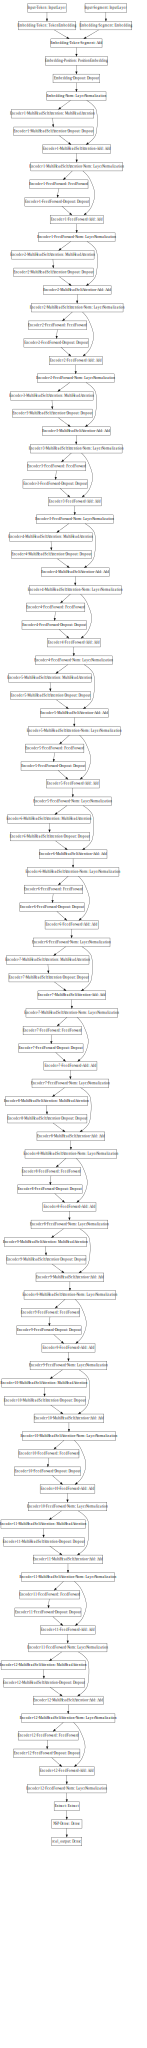

In [0]:
from IPython.display import SVG
from keras.utils import model_to_dot


SVG(model_to_dot(get_bert_finetuning_model(model), dpi=65).create(prog='dot', format='svg'))


In [0]:
sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init = tf.variables_initializer([v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables])
sess.run(init)

bert_model = get_bert_finetuning_model(model)
history = bert_model.fit(train_x, train_y, epochs=2, batch_size=16, verbose = 1, validation_data=(test_x, test_y), shuffle=True)

Train on 3900 samples, validate on 1672 samples
Epoch 1/2
3900/3900 [==============================] - 107s 28ms/step - loss: 0.2318 - acc: 0.9797 - val_loss: 0.0419 - val_acc: 0.9964
Epoch 2/2
3900/3900 [==============================] - 86s 22ms/step - loss: 0.0412 - acc: 0.9944 - val_loss: 0.0176 - val_acc: 0.9982


In [0]:
def predict_convert_data(data):
    global tokenizer
    indices = []
    for i in tqdm(range(len(data))):
        ids, segments = tokenizer.encode(data[i], max_len=SEQ_LEN)
        indices.append(ids)
        
    items = indices
    
    
    indices = np.array(indices)
    return [indices, np.zeros_like(indices)]

def predict_load_data(x): #Pandas Dataframe을 인풋으로 받는다
    data = np.array(x[DATA_COLUMN])
    data_x = predict_convert_data(data)

    return data_x

In [0]:
test_set = predict_load_data(test_set)

100%|██████████| 558/558 [00:00<00:00, 5041.29it/s]

['Where r we meeting?' 'R u still working now?'
 'I send the print  outs da.'
 'Sorry . I will be able to get to you. See you in the morning.'
 'Designation is software developer and may be she get chennai:)'
 'Studying. But i.ll be free next weekend.'
 'Had your mobile 10 mths? Update to the latest Camera/Video phones for FREE. KEEP UR SAME NUMBER, Get extra free mins/texts. Text YES for a call'
 "Ask g or iouri, I've told the story like ten times already"
 'That seems unnecessarily hostile' 'Jus chillaxin, what up'
 'Hi baby ive just got back from work and i was wanting to see u allday! I hope i didnt piss u off on the phone today. If u are up give me a call xxx'
 'I cant pick the phone right now. Pls send a message'
 "We'll join the  &lt;#&gt;  bus"
 'Free entry to the gr8prizes wkly comp 4 a chance to win the latest Nokia 8800, PSP or �250 cash every wk.TXT GREAT to 80878 http//www.gr8prizes.com 08715705022'
 '\\BOO BABE! U ENJOYIN YOURJOB? U SEEMED 2 B GETTIN ON WELL HUNNY!HOPE UR

In [0]:
preds = bert_model.predict(test_set)

In [0]:
preds

array([[0.99060357],
       [0.99061227],
       [0.9910555 ],
       [0.99092543],
       [0.98860216],
       [0.99061596],
       [0.0149028 ],
       [0.99068713],
       [0.99004185],
       [0.9906473 ],
       [0.99059045],
       [0.99076355],
       [0.99064434],
       [0.01457968],
       [0.98913395],
       [0.9874653 ],
       [0.99068546],
       [0.9898163 ],
       [0.9910106 ],
       [0.9908594 ],
       [0.99054897],
       [0.9911484 ],
       [0.9908887 ],
       [0.9905879 ],
       [0.9904436 ],
       [0.99085844],
       [0.9872651 ],
       [0.9910434 ],
       [0.99103725],
       [0.01494187],
       [0.9909258 ],
       [0.99049556],
       [0.98732936],
       [0.9905672 ],
       [0.99061704],
       [0.01437253],
       [0.01456472],
       [0.9882904 ],
       [0.99096155],
       [0.99040383],
       [0.99017406],
       [0.9897207 ],
       [0.01443917],
       [0.99040216],
       [0.9908459 ],
       [0.98470974],
       [0.9907857 ],
       [0.990

In [0]:
from sklearn.metrics import classification_report

In [0]:
y_true = []
for test_set

In [0]:
y_true = test['label']
# F1 Score 확인
print(classification_report(y_true, np.round(preds,0)))